# import essentials

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

# Importing visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Importing model building packages
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn import preprocessing,metrics 

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb


from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [3]:
train_data=pd.read_csv("train_s3TEQDk.csv")
test_data=pd.read_csv("test_mSzZ8RL.csv")
sample_data=pd.read_csv("sample_submission_eyYijxG.csv")

In [4]:
train_data.head()

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   
3  BF3NC7KV    Male   34       RG270       Salaried           X1       19   
4  TEASRWXV  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0  
3             No               470454        No        0  
4             No               886787        No        0

In [5]:
train_data.groupby("Is_Lead").count()

## Data imbalance in our training data 

ID  Gender     Age  Region_Code  Occupation  Channel_Code  \
Is_Lead                                                                  
0        187437  187437  187437       187437      187437        187437   
1         58288   58288   58288        58288       58288         58288   

         Vintage  Credit_Product  Avg_Account_Balance  Is_Active  
Is_Lead                                                           
0         187437          183087               187437     187437  
1          58288           33313                58288      58288

# Describe the Data

In [6]:
train_data.describe()

Age        Vintage  Avg_Account_Balance        Is_Lead
count  245725.000000  245725.000000         2.457250e+05  245725.000000
mean       43.856307      46.959141         1.128403e+06       0.237208
std        14.828672      32.353136         8.529364e+05       0.425372
min        23.000000       7.000000         2.079000e+04       0.000000
25%        30.000000      20.000000         6.043100e+05       0.000000
50%        43.000000      32.000000         8.946010e+05       0.000000
75%        54.000000      73.000000         1.366666e+06       0.000000
max        85.000000     135.000000         1.035201e+07       1.000000

# info

In [7]:
#observe the different feature type present in the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


# Categorical Feature Encoding

## Categorical cols Distribution

In [8]:
train_data.drop(["ID"],axis=1,inplace=True) # Dropping the Id column
features=train_data.columns.values
categorical_features=train_data.select_dtypes(include="object").columns.tolist() # list of only categorical features
numerical_features=train_data.select_dtypes(include=np.number).columns.tolist() # List of only numerical features 
print("categorical features Columns",categorical_features)
print("numerical Features Columns",numerical_features)

categorical features Columns ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
numerical Features Columns ['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead']


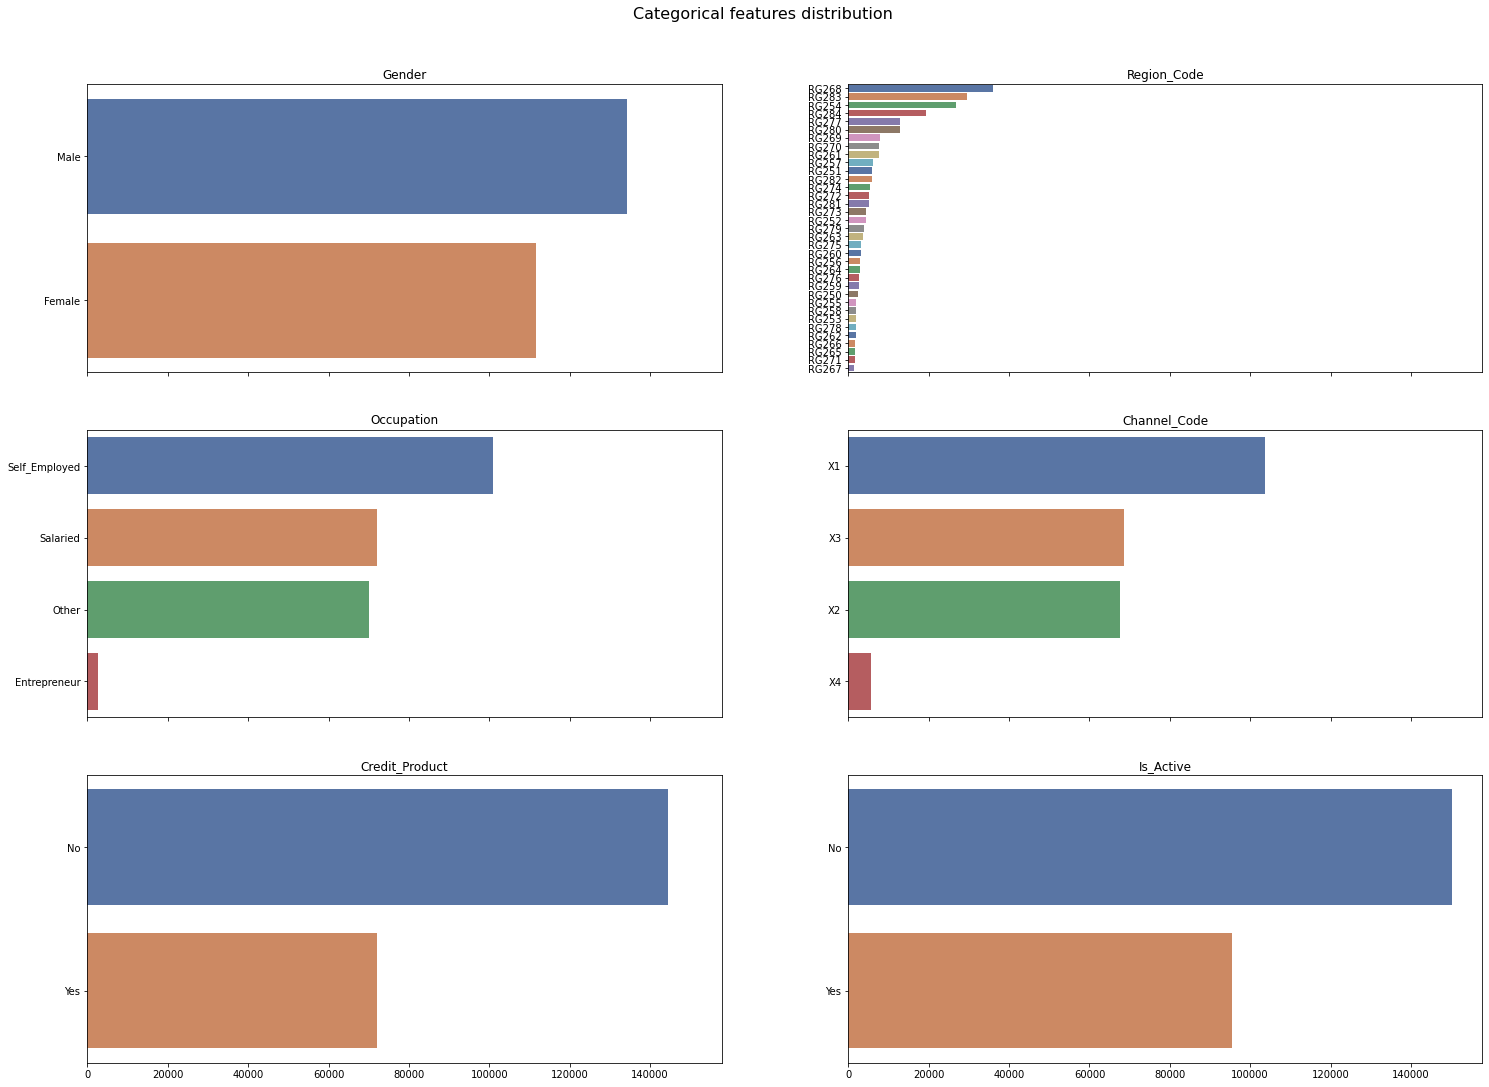

In [9]:
### Categorical features distribution
idx=0
f,axes=plt.subplots(3,2,sharex=True,figsize=(25,18))
plt.suptitle('Categorical features distribution', size=16, y=(0.94))

for row in range(3):
    for col in range(2):
        data=train_data[categorical_features[idx]].value_counts()
        sns.barplot(x=data.values,y=data.index,palette="deep",ax=axes[row,col])
        axes[row,col].set_title(categorical_features[idx])
        idx+=1

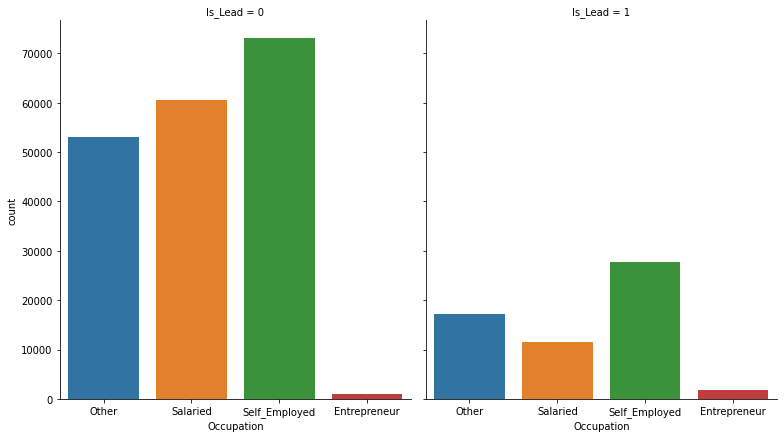

In [10]:
sns.catplot(x="Occupation",col='Is_Lead',
           data=train_data,kind='count',
           height=6,aspect=.9);

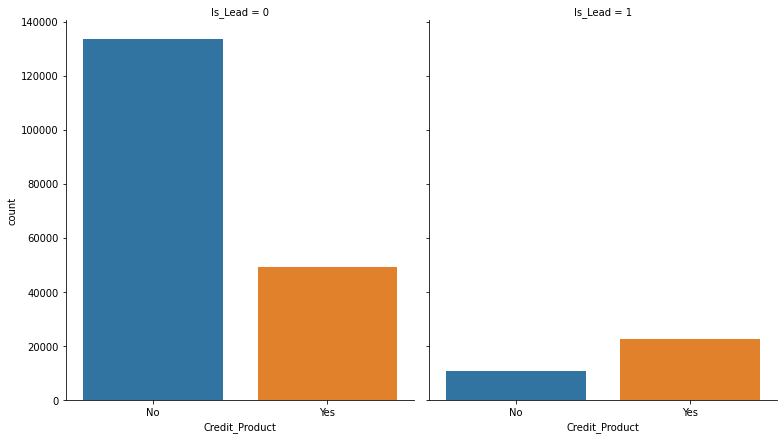

In [11]:
sns.catplot(x="Credit_Product",col='Is_Lead',
           data=train_data,kind='count',
           height=6,aspect=.9);

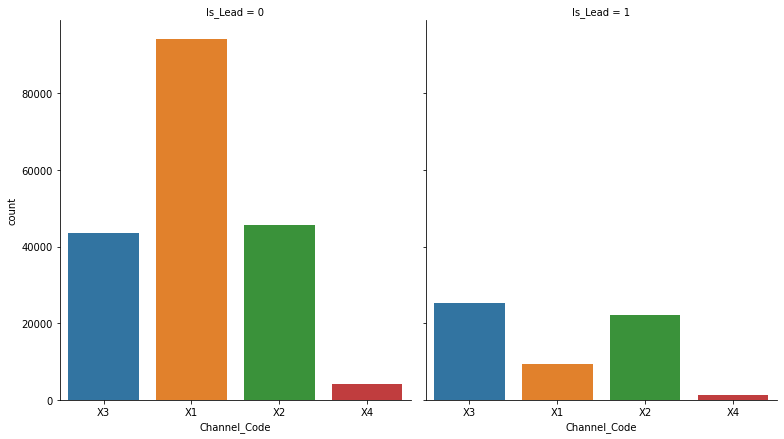

In [12]:
sns.catplot(x="Channel_Code",col='Is_Lead',
           data=train_data,kind='count',
           height=6,aspect=.9);

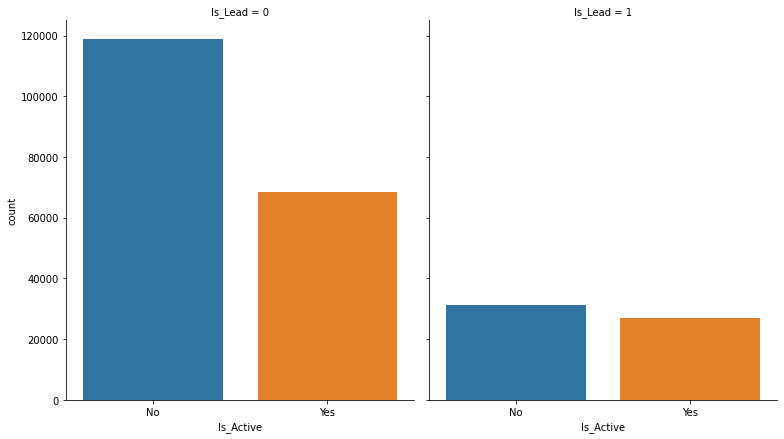

In [13]:
sns.catplot(x="Is_Active", col="Is_Lead",
                data=train_data, kind="count",
                height=6, aspect=.9);

## Encoding Cat features

In [14]:
train_data["Region_Code"].unique()

array(['RG268', 'RG277', 'RG270', 'RG282', 'RG261', 'RG265', 'RG283',
       'RG254', 'RG269', 'RG257', 'RG279', 'RG280', 'RG252', 'RG284',
       'RG259', 'RG281', 'RG258', 'RG266', 'RG260', 'RG274', 'RG256',
       'RG275', 'RG273', 'RG267', 'RG272', 'RG251', 'RG262', 'RG264',
       'RG278', 'RG276', 'RG263', 'RG250', 'RG255', 'RG253', 'RG271'],
      dtype=object)

In [15]:
#Data Encoding
train_data["Gender"]=train_data["Gender"].replace({"Female":0,"Male":1})
train_data["Occupation"]=train_data["Occupation"].replace({"Self_Employed":1,"Salaried":2,"Other":3,"Entrepreneur":4})
train_data["Channel_Code"]=train_data["Channel_Code"].replace({'X1':'1','X2':'2','X3':'3','X4':'4'})
train_data["Credit_Product"]       = train_data["Credit_Product"].replace({'No':'1','Yes':'2'})
train_data["Is_Active"]            = train_data["Is_Active"].replace({'No':'1','Yes':'2'})
train_data["Region_Code"]          = train_data["Region_Code"].apply(lambda x:x[2:])

In [16]:
train_data["Region_Code"]      =pd.to_numeric(train_data["Region_Code"])
train_data["Channel_Code"]     = pd.to_numeric(train_data["Channel_Code"])
train_data["Credit_Product"]   = pd.to_numeric(train_data["Credit_Product"])
train_data["Is_Active"]        = pd.to_numeric(train_data["Is_Active"])

# EDA (Exploratory Data Analysis)

## Numericals Columns Distribution


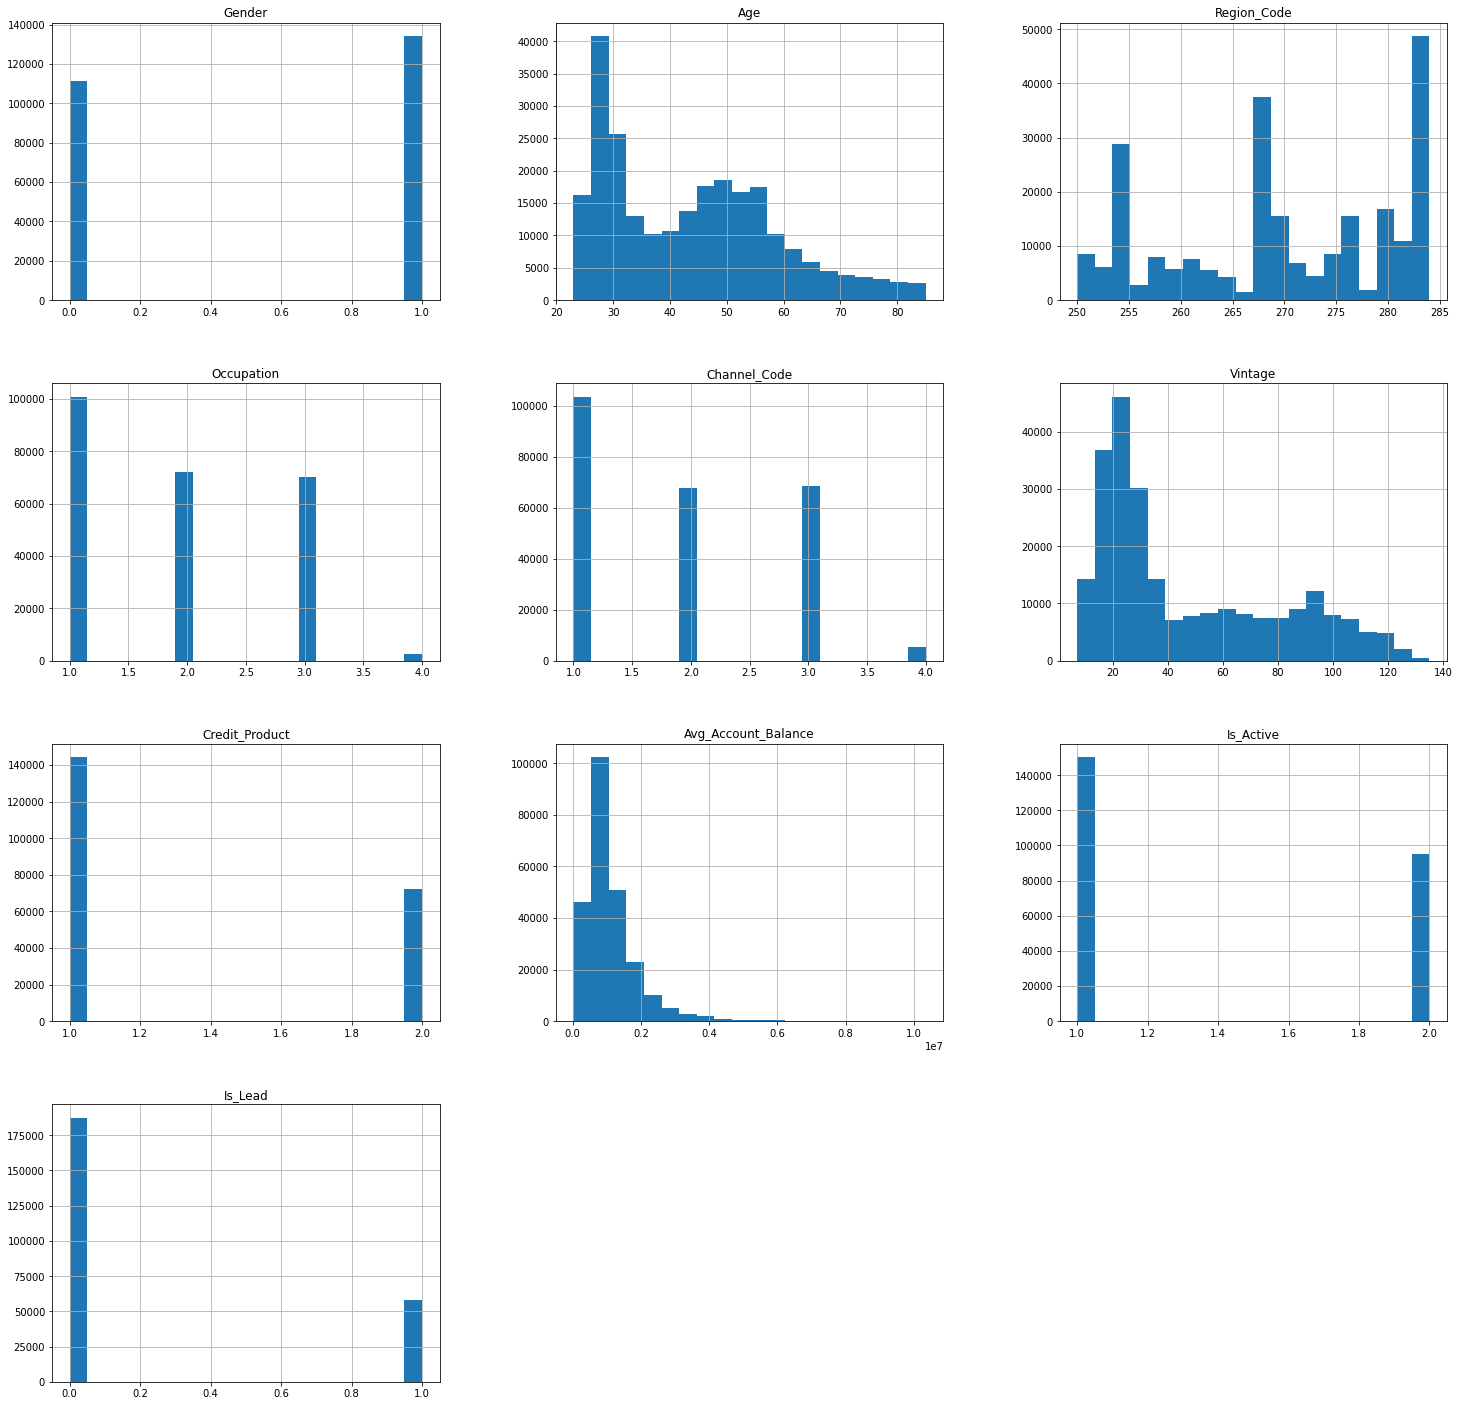

In [17]:
train_data.hist(bins=20,figsize=(25,25))
plt.show()

## Scatter Plot

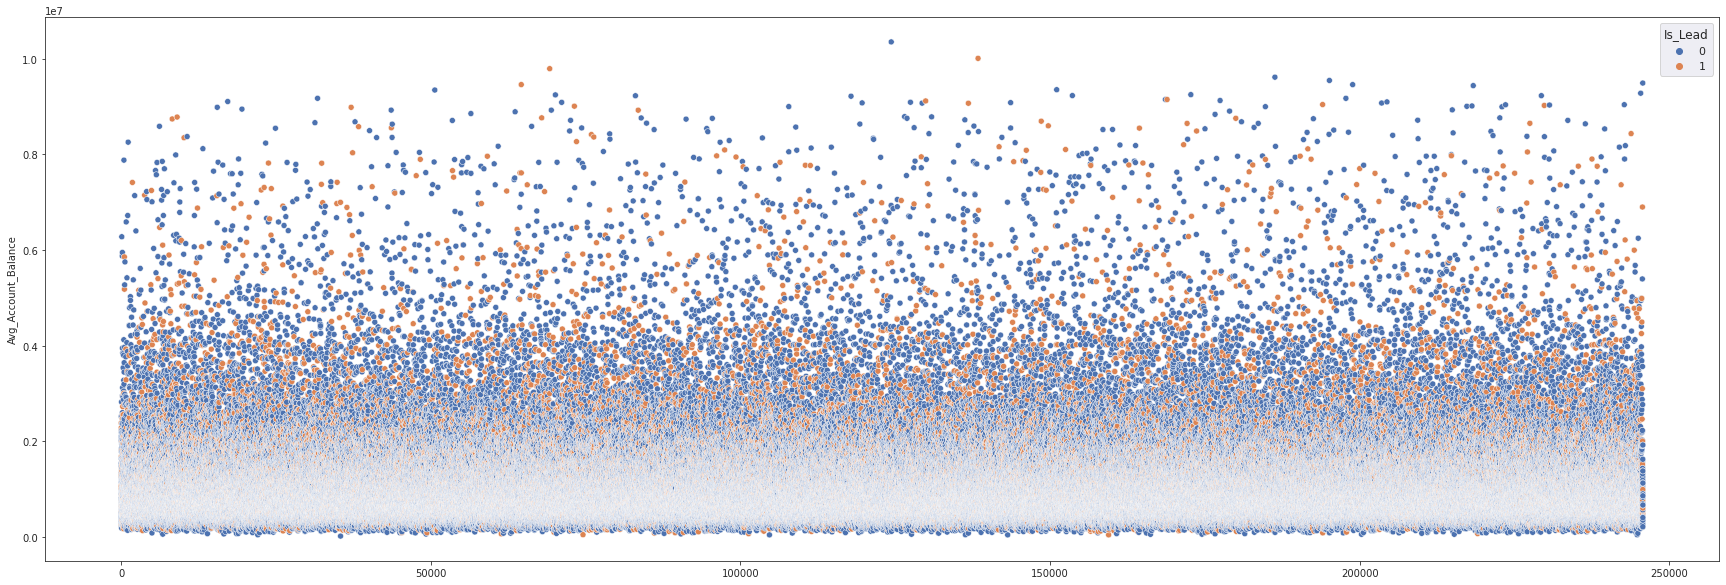

In [18]:
#Plot
sns.set_style("ticks")
fig,ax=plt.subplots()
fig.set_size_inches(30,10)
sns.set_theme(style="darkgrid")
sns.scatterplot(x=train_data.index,y=train_data["Avg_Account_Balance"],hue=train_data['Is_Lead']);

In [19]:
# bivariate analysis by plotting pair plot
# pair-plot
# plt.close()
# sns.set_style("whitegrid")
# sns.pairplot(train_data, hue="Is_Lead", height=3)
# plt.show()

## Plotting Distribution of all the features

<Figure size 432x288 with 0 Axes>

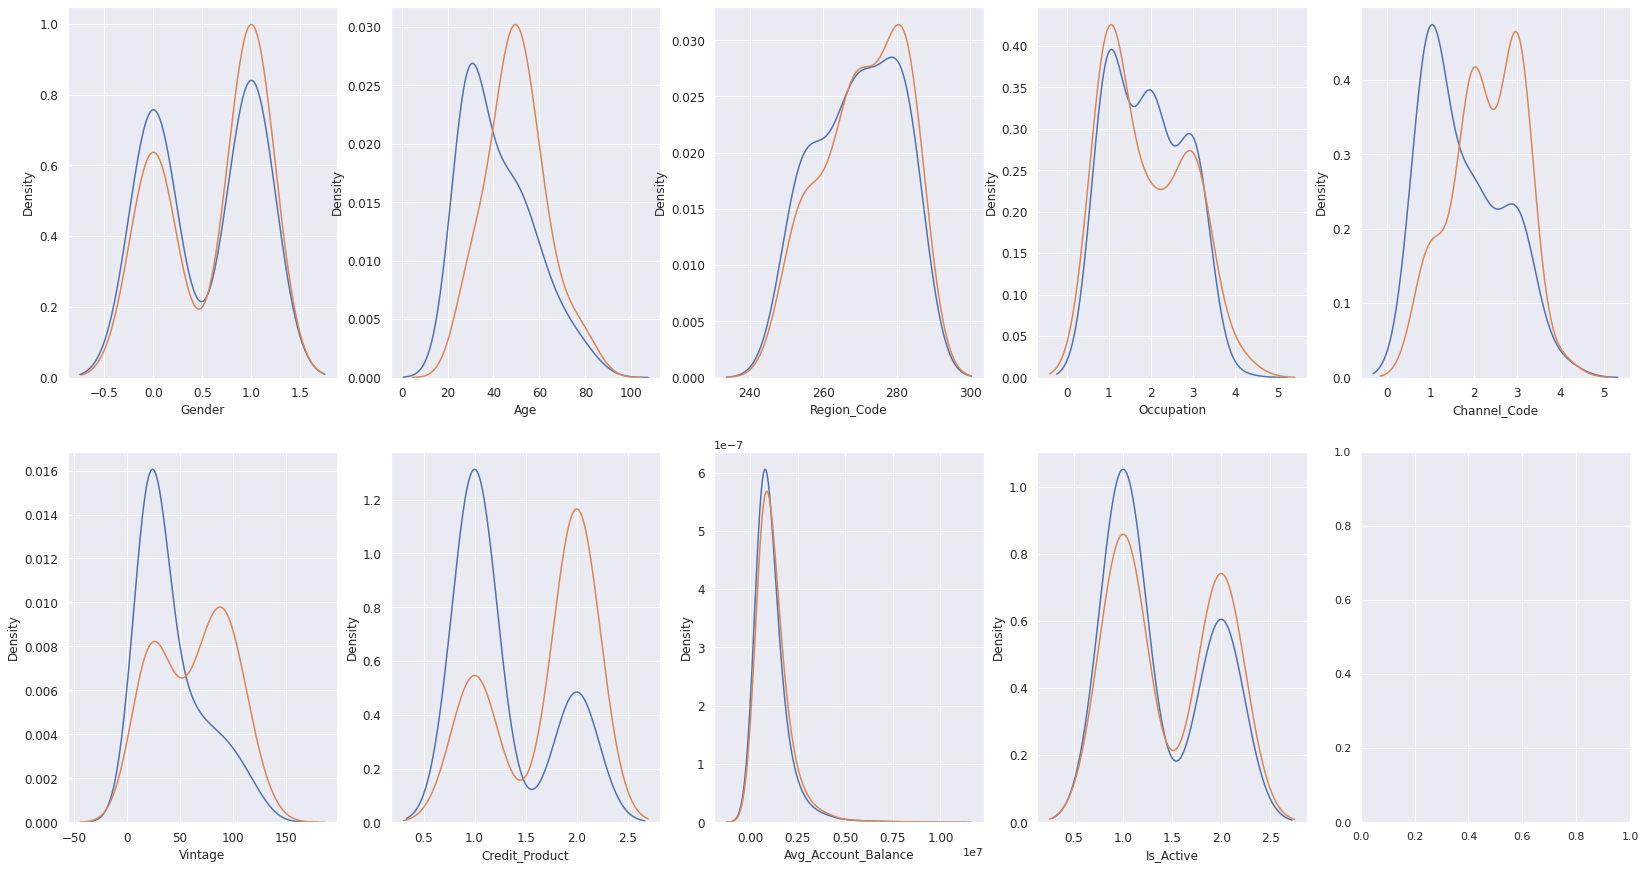

In [20]:
#Plotting the distributions of all the featuers

# Plotting numerical variable in displot to visualise the distribution
train_num=train_data.select_dtypes(include="number")
var=list(train_num.columns.values)
# dropping Class columns from the list
var.remove("Is_Lead")
i=0
t0=train_data.loc[train_data["Is_Lead"]==0]
t1=train_data.loc[train_data["Is_Lead"]==1]
plt.figure()
fig, ax = plt.subplots(2,5,figsize=(28,15))
for feature in var:
    i+=1

    plt.subplot(2,5,i)
    sns.kdeplot(t0[feature],bw=0.5,label=0)
    sns.kdeplot(t1[feature],bw=0.5,label=1)
    plt.xlabel(feature,fontsize=12)
    locs,labels=plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()


### Avg_Account_Balance is Highly Overlapping so it is better to remove

In [21]:
# train_data.drop(["Avg_Account_Balance"],axis=1,inplace=True)#dropping Avg_Account_Balance col

# Handling missing Values

In [22]:
# Checking for the missing value present in each columns
total=train_data.isnull().sum().sort_values(ascending=False)
percent=(train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending=False)
pd.concat([total,percent],axis=1,keys=["Total","percent"]).transpose()

Credit_Product  Gender  Age  Region_Code  Occupation  Channel_Code  \
Total      29325.000000     0.0  0.0          0.0         0.0           0.0   
percent       11.934073     0.0  0.0          0.0         0.0           0.0   

         Vintage  Avg_Account_Balance  Is_Active  Is_Lead  
Total        0.0                  0.0        0.0      0.0  
percent      0.0                  0.0        0.0      0.0

In [23]:
train_data.groupby("Credit_Product").count()

Gender     Age  Region_Code  Occupation  Channel_Code  \
Credit_Product                                                          
1.0             144357  144357       144357      144357        144357   
2.0              72043   72043        72043       72043         72043   

                Vintage  Avg_Account_Balance  Is_Active  Is_Lead  
Credit_Product                                                    
1.0              144357               144357     144357   144357  
2.0               72043                72043      72043    72043

In [24]:
#imputing Credit_Product Nan values with the new value 3
train_data["Credit_Product"]=train_data["Credit_Product"].fillna(3)
# again Checking for the missing value present in each columns
total=train_data.isnull().sum().sort_values(ascending=False)
percent=(train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending=False)
pd.concat([total,percent],axis=1,keys=["Total","percent"]).transpose()

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
Total       0.0  0.0          0.0         0.0           0.0      0.0   
percent     0.0  0.0          0.0         0.0           0.0      0.0   

         Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  
Total               0.0                  0.0        0.0      0.0  
percent             0.0                  0.0        0.0      0.0

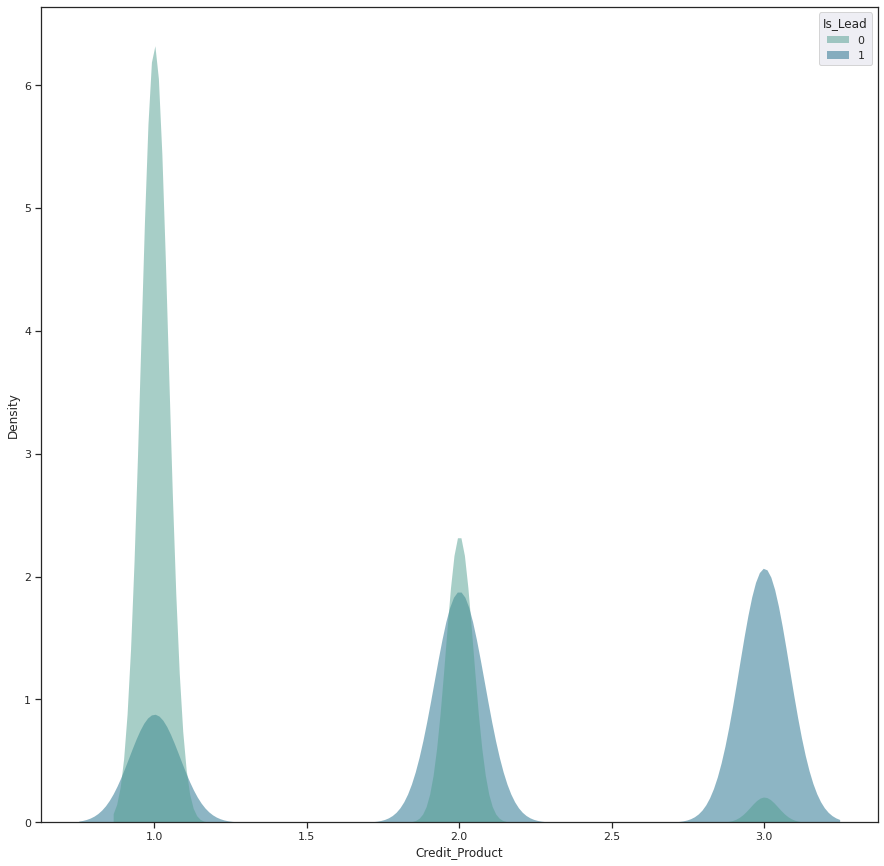

In [25]:
# Plot
sns.set_style('ticks')
fig,ax=plt.subplots()
fig.set_size_inches(15,15)
sns.set_theme(style="darkgrid")
sns.kdeplot(data=train_data,
           x="Credit_Product",
           hue="Is_Lead",
           fill=True,
           common_norm=False,
           palette="crest",
           alpha=.5,
           linewidth=0);

# Feature Engineering

In [26]:
train=train_data.copy()
train.head()

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0       0   73          268           3             3       43   
1       0   30          277           2             1       32   
2       0   56          268           1             3       26   
3       1   34          270           2             1       19   
4       0   30          282           2             1       33   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  
0             1.0              1045696          1        0  
1             1.0               581988          1        0  
2             1.0              1484315          2        0  
3             1.0               470454          1        0  
4             1.0               886787          1        0

## Binning on age

In [27]:
train.loc[train["Age"].idxmax()]

Gender                      1.0
Age                        85.0
Region_Code               282.0
Occupation                  3.0
Channel_Code                3.0
Vintage                   115.0
Credit_Product              2.0
Avg_Account_Balance    891513.0
Is_Active                   1.0
Is_Lead                     0.0
Name: 411, dtype: float64

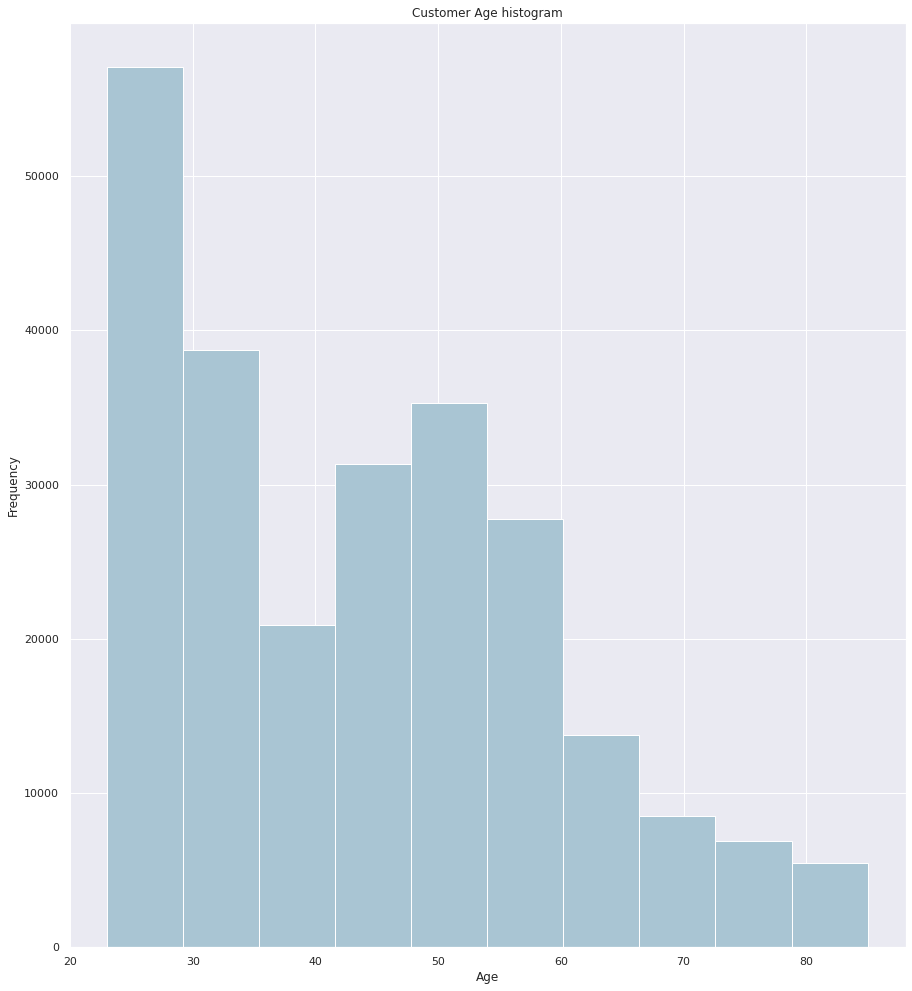

In [28]:
fig,ax=plt.subplots(figsize=(15,17))
train["Age"].hist(color='#A9C5D3')
ax.set_title("Customer Age histogram")
ax.set_xlabel("Age",fontsize=12)
ax.set_ylabel("Frequency",fontsize=12);

Age bins range

23 -  29  : 2

30 - 39  : 3

40 - 49  : 4

50 - 59  : 5

60 - 69  : 6

70 - 579  : 7

80 - 85  : 8

In [29]:
train["Age_bins"]=np.array(np.floor(np.array(train["Age"])/10.))
train.iloc[20:25]

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
20       1   44          269           1             2       19   
21       1   27          257           2             1       21   
22       0   32          279           2             1       26   
23       1   50          280           1             3       99   
24       0   31          282           2             1       33   

    Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  Age_bins  
20             2.0              1001650          1        1       4.0  
21             1.0              1239342          1        0       2.0  
22             1.0              1339779          2        0       3.0  
23             1.0               887330          2        0       5.0  
24             1.0               396806          1        0       3.0

## Binarization on Occupation
create a column, if there is a 4 in the occupation it will put 1 corresponds to 4

In [30]:
occupation_binary=np.array(train["Occupation"])
train["Occupation_binary"]=train["Occupation"].map(lambda x:1 if x==4 else 0)
train.head()

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0       0   73          268           3             3       43   
1       0   30          277           2             1       32   
2       0   56          268           1             3       26   
3       1   34          270           2             1       19   
4       0   30          282           2             1       33   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  Age_bins  \
0             1.0              1045696          1        0       7.0   
1             1.0               581988          1        0       3.0   
2             1.0              1484315          2        0       5.0   
3             1.0               470454          1        0       3.0   
4             1.0               886787          1        0       3.0   

   Occupation_binary  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0

## Modifying vintage month to year

In [31]:
train['vintage_yr'] = np.array(np.floor(np.array(train['Vintage']) / 12.))
train.head(8)

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0       0   73          268           3             3       43   
1       0   30          277           2             1       32   
2       0   56          268           1             3       26   
3       1   34          270           2             1       19   
4       0   30          282           2             1       33   
5       1   56          261           1             1       32   
6       1   62          282           3             3       20   
7       0   48          265           1             3       13   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  Age_bins  \
0             1.0              1045696          1        0       7.0   
1             1.0               581988          1        0       3.0   
2             1.0              1484315          2        0       5.0   
3             1.0               470454          1        0       3.0   
4             1.0               886787          1        0       3.0   
5             1.0               544163          2        0       5.0   
6             3.0              1056750          2        1       6.0   
7             1.0               444724          2        0       4.0   

   Occupation_binary  vintage_yr  
0                  0         3.0  
1                  0         2.0  
2                  0         2.0  
3                  0         1.0  
4                  0         2.0  
5                  0         2.0  
6                  0         1.0  
7                  0         1.0

## Binarization on Credit product
create a column, if there is a 3 in the Credit product it will put 1 corresponds to 3

In [32]:
train["Credit_Product_binary"]=train["Credit_Product"].map(lambda x:1 if x==3 else 0)
train.head()

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0       0   73          268           3             3       43   
1       0   30          277           2             1       32   
2       0   56          268           1             3       26   
3       1   34          270           2             1       19   
4       0   30          282           2             1       33   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  Age_bins  \
0             1.0              1045696          1        0       7.0   
1             1.0               581988          1        0       3.0   
2             1.0              1484315          2        0       5.0   
3             1.0               470454          1        0       3.0   
4             1.0               886787          1        0       3.0   

   Occupation_binary  vintage_yr  Credit_Product_binary  
0                  0         3.0                      0  
1                  0         2.0                      0  
2                  0         2.0                      0  
3                  0         1.0                      0  
4                  0         2.0                      0

## Binning Avg_Account_Balance with inter quartile range

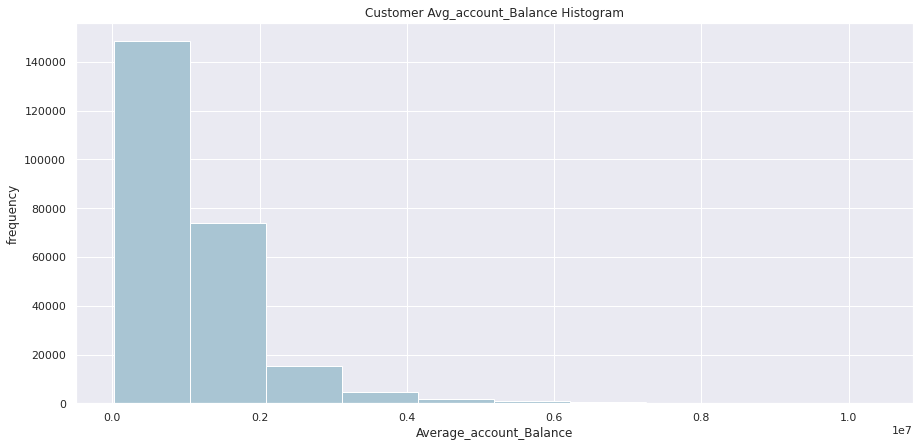

In [33]:
fig,ax=plt.subplots(figsize=(15,7))
train["Avg_Account_Balance"].hist(color="#A9C5D3")
ax.set_title("Customer Avg_account_Balance Histogram",fontsize=12)
ax.set_xlabel("Average_account_Balance",fontsize=12)
ax.set_ylabel("frequency",fontsize=12);

In [34]:
quantiles_range=[0,.25,.5,.75,1.]
quantiles=train["Avg_Account_Balance"].quantile(quantiles_range)
print(quantiles)

0.00       20790.0
0.25      604310.0
0.50      894601.0
0.75     1366666.0
1.00    10352009.0
Name: Avg_Account_Balance, dtype: float64


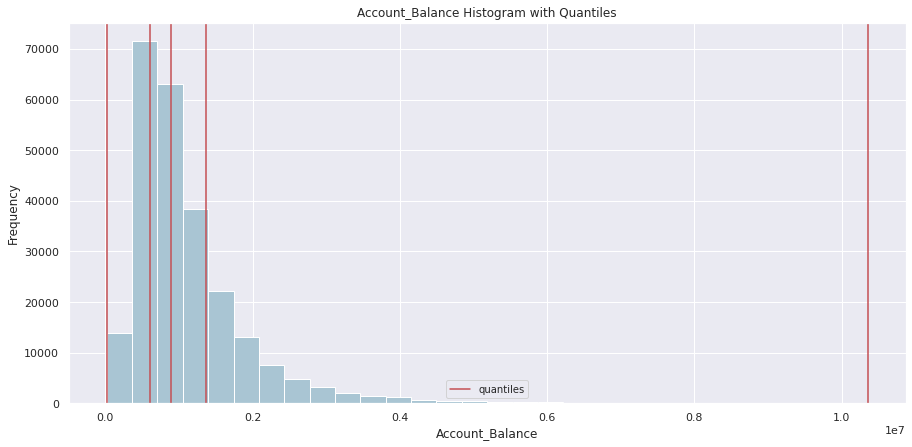

In [35]:
fig,ax=plt.subplots(figsize=(15,7))
train["Avg_Account_Balance"].hist(bins=30,color="#A9C5D3")
for quantile in quantiles:
    qvl=plt.axvline(quantile,color='r')
ax.legend([qvl],['quantiles'],fontsize=10)

ax.set_title('Account_Balance Histogram with Quantiles', fontsize=12)
ax.set_xlabel('Account_Balance', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12);

In [36]:
quantile_labels=["25","50","75","100"]
train["Avg_account_Balance_quantile"]=pd.qcut(train["Avg_Account_Balance"],q=quantiles_range,labels=quantile_labels)
train.iloc[4:9]

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
4       0   30          282           2             1       33   
5       1   56          261           1             1       32   
6       1   62          282           3             3       20   
7       0   48          265           1             3       13   
8       0   40          283           1             2       38   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  Age_bins  \
4             1.0               886787          1        0       3.0   
5             1.0               544163          2        0       5.0   
6             3.0              1056750          2        1       6.0   
7             1.0               444724          2        0       4.0   
8             1.0              1274284          1        0       4.0   

   Occupation_binary  vintage_yr  Credit_Product_binary  \
4                  0         2.0                      0   
5                  0         2.0                      0   
6                  0         1.0                      1   
7                  0         1.0                      0   
8                  0         3.0                      0   

  Avg_account_Balance_quantile  
4                           50  
5                           25  
6                           75  
7                           25  
8                           75

## log transformation on Avg_Account_Balance with inter quartile range

In [37]:
train["Avg_account_Balance_log"]=np.log(1+train["Avg_Account_Balance"])
train.iloc[4:9]

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
4       0   30          282           2             1       33   
5       1   56          261           1             1       32   
6       1   62          282           3             3       20   
7       0   48          265           1             3       13   
8       0   40          283           1             2       38   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  Age_bins  \
4             1.0               886787          1        0       3.0   
5             1.0               544163          2        0       5.0   
6             3.0              1056750          2        1       6.0   
7             1.0               444724          2        0       4.0   
8             1.0              1274284          1        0       4.0   

   Occupation_binary  vintage_yr  Credit_Product_binary  \
4                  0         2.0                      0   
5                  0         2.0                      0   
6                  0         1.0                      1   
7                  0         1.0                      0   
8                  0         3.0                      0   

  Avg_account_Balance_quantile  Avg_account_Balance_log  
4                           50                13.695361  
5                           25                13.207006  
6                           75                13.870710  
7                           25                13.005211  
8                           75                14.057896

In [38]:
train["Avg_account_Balance_quantile"]=pd.to_numeric(train["Avg_account_Balance_quantile"])

## Create another column where convert the balance of last 12 months(1yr) balance into 1 month

In [39]:
train["Avg_Account_Balance_monthly"]=np.array(np.floor(np.array(train["Avg_Account_Balance"])/12.))
train.head()

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0       0   73          268           3             3       43   
1       0   30          277           2             1       32   
2       0   56          268           1             3       26   
3       1   34          270           2             1       19   
4       0   30          282           2             1       33   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  Age_bins  \
0             1.0              1045696          1        0       7.0   
1             1.0               581988          1        0       3.0   
2             1.0              1484315          2        0       5.0   
3             1.0               470454          1        0       3.0   
4             1.0               886787          1        0       3.0   

   Occupation_binary  vintage_yr  Credit_Product_binary  \
0                  0         3.0                      0   
1                  0         2.0                      0   
2                  0         2.0                      0   
3                  0         1.0                      0   
4                  0         2.0                      0   

   Avg_account_Balance_quantile  Avg_account_Balance_log  \
0                            75                13.860194   
1                            25                13.274207   
2                           100                14.210465   
3                            25                13.061456   
4                            50                13.695361   

   Avg_Account_Balance_monthly  
0                      87141.0  
1                      48499.0  
2                     123692.0  
3                      39204.0  
4                      73898.0

## if Is_Active = 2(yes) which means customer is active in last three months. I'll put 1 corresponds to 2(yes) 

In [40]:
is_active=np.array(train["Is_Active"])
train["is_Active_3(yes)"]=train["Is_Active"].map(lambda x : 1 if x==2 else 0)
train.head()

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0       0   73          268           3             3       43   
1       0   30          277           2             1       32   
2       0   56          268           1             3       26   
3       1   34          270           2             1       19   
4       0   30          282           2             1       33   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  Age_bins  \
0             1.0              1045696          1        0       7.0   
1             1.0               581988          1        0       3.0   
2             1.0              1484315          2        0       5.0   
3             1.0               470454          1        0       3.0   
4             1.0               886787          1        0       3.0   

   Occupation_binary  vintage_yr  Credit_Product_binary  \
0                  0         3.0                      0   
1                  0         2.0                      0   
2                  0         2.0                      0   
3                  0         1.0                      0   
4                  0         2.0                      0   

   Avg_account_Balance_quantile  Avg_account_Balance_log  \
0                            75                13.860194   
1                            25                13.274207   
2                           100                14.210465   
3                            25                13.061456   
4                            50                13.695361   

   Avg_Account_Balance_monthly  is_Active_3(yes)  
0                      87141.0                 0  
1                      48499.0                 0  
2                     123692.0                 1  
3                      39204.0                 0  
4                      73898.0                 0

## Create columns that has product of weak features
5 weak features


1.   Age
2.   Vintage
3.   region code
4.   Avg_Account_Balance_quantile
5.   Avg_Account_Balance_log



It will create three more feature





In [41]:
train['combination1']   = train['Age']  * train['Vintage']
train['combination2']   = train['Vintage']  * train['Region_Code'] 
train['combination3']   = train['Region_Code'] * train['Age']
train['combination4']   = train['Age']  * train['Vintage'] * train['Region_Code']
train['combination5']   = train['Vintage']  * train['Region_Code'] * train['Avg_account_Balance_quantile'] 
train['combination6']   = train['Avg_account_Balance_quantile'] * train['Age']  * train['Avg_account_Balance_log']
train

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0            0   73          268           3             3       43   
1            0   30          277           2             1       32   
2            0   56          268           1             3       26   
3            1   34          270           2             1       19   
4            0   30          282           2             1       33   
...        ...  ...          ...         ...           ...      ...   
245720       1   51          284           1             3      109   
245721       1   27          268           2             1       15   
245722       0   26          281           2             1       13   
245723       0   28          273           2             1       31   
245724       1   29          269           2             1       21   

        Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  ...  \
0                  1.0              1045696          1        0  ...   
1                  1.0               581988          1        0  ...   
2                  1.0              1484315          2        0  ...   
3                  1.0               470454          1        0  ...   
4                  1.0               886787          1        0  ...   
...                ...                  ...        ...      ...  ...   
245720             3.0              1925586          1        0  ...   
245721             1.0               862952          2        0  ...   
245722             1.0               670659          1        0  ...   
245723             1.0               407504          1        0  ...   
245724             1.0              1129276          1        0  ...   

        Avg_account_Balance_quantile  Avg_account_Balance_log  \
0                                 75                13.860194   
1                                 25                13.274207   
2                                100                14.210465   
3                                 25                13.061456   
4                                 50                13.695361   
...                              ...                      ...   
245720                           100                14.470741   
245721                            50                13.668116   
245722                            50                13.416018   
245723                            25                12.917808   
245724                            75                13.937088   

        Avg_Account_Balance_monthly  is_Active_3(yes)  combination1  \
0                           87141.0                 0          3139   
1                           48499.0                 0           960   
2                          123692.0                 1          1456   
3                           39204.0                 0           646   
4                           73898.0                 0           990   
...                             ...               ...           ...   
245720                     160465.0                 0          5559   
245721                      71912.0                 1           405   
245722                      55888.0                 0           338   
245723                      33958.0                 0           868   
245724                      94106.0                 0           609   

        combination2  combination3  combination4  combination5  combination6  
0              11524         19564        841252        864300  75884.563282  
1               8864          8310        265920        221600   9955.655120  
2               6968         15008        390208        696800  79578.601861  
3               5130          9180        174420        128250  11102.237252  
4               9306          8460        279180        465300  20543.041837  
...              ...           ...           ...           ...           ...  
245720         30956         14484       1578756       3095600  73800.781213  
245721          4020    

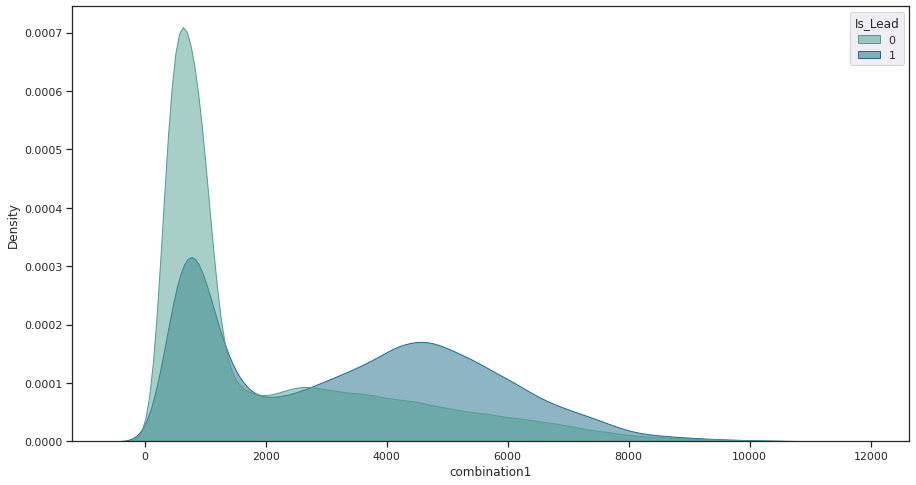

In [42]:
# plot
sns.set_style("ticks")
fig,ax=plt.subplots()
fig.set_size_inches(15,8)
sns.set_theme(style="darkgrid")
sns.kdeplot(data=train,
           x="combination1",
           hue="Is_Lead",
           fill=True,
           common_norm=False,
           palette="crest",
           alpha=.5,
           linewidth=1);

# Analysis on new Modified data

<Figure size 432x288 with 0 Axes>

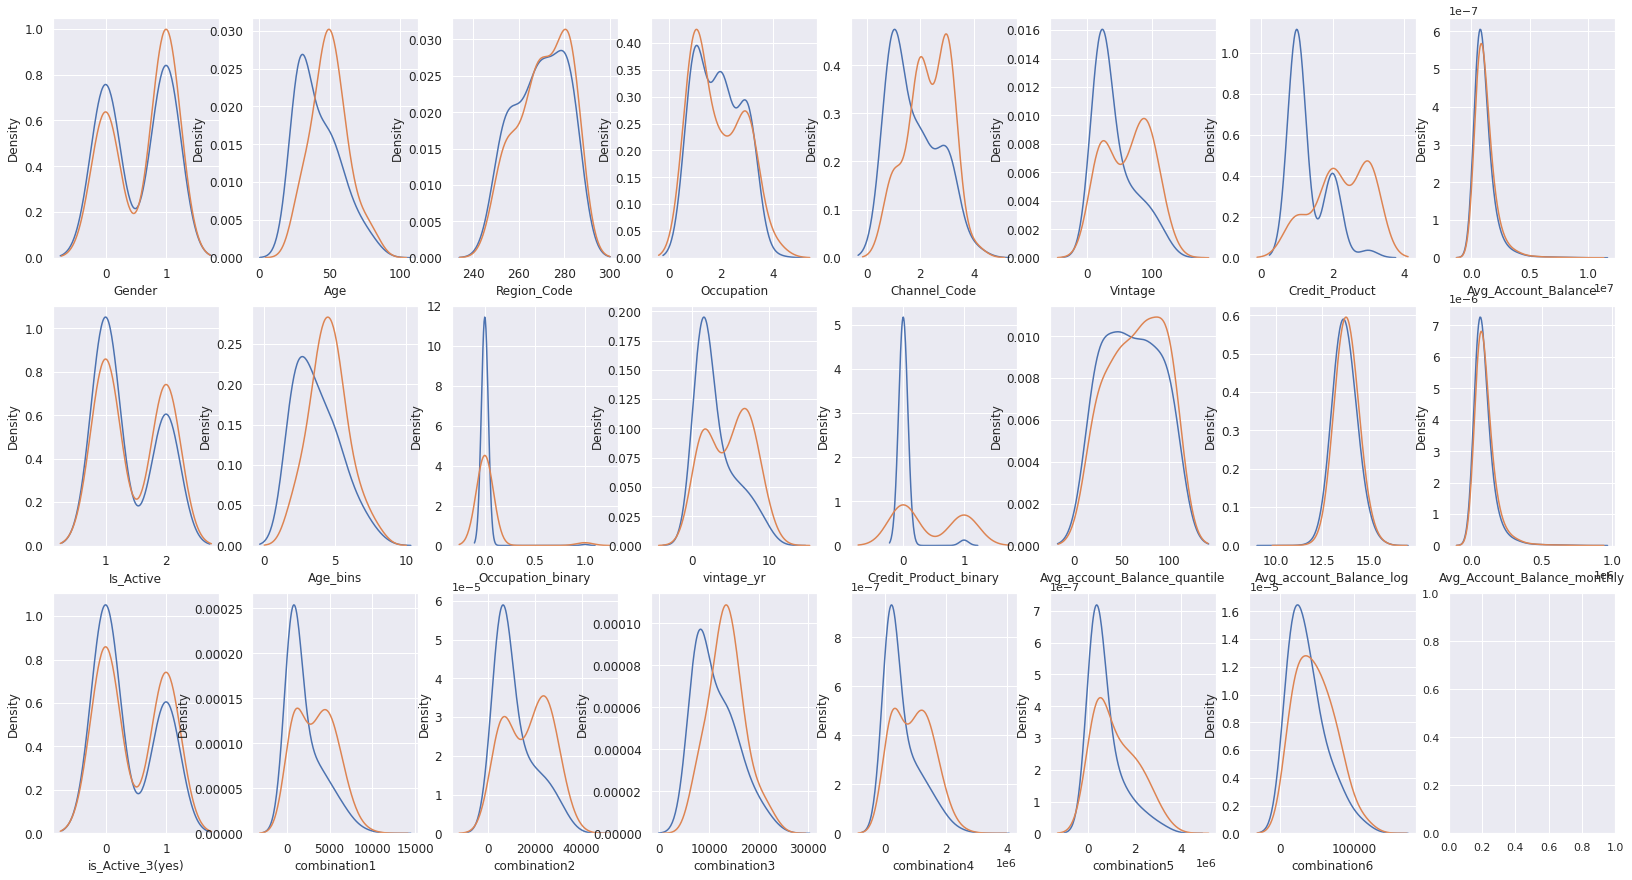

In [43]:
#Plotting the distributions of all the featuers

# Plotting numerical variable in displot to visualise the distribution

train_num=train.select_dtypes(include="number")
var=list(train_num.columns.values)
# dropping Class columns from the list
var.remove("Is_Lead")
i=0
t0=train.loc[train["Is_Lead"]==0]
t1=train.loc[train["Is_Lead"]==1]

plt.figure()
fig,ax=plt.subplots(3,8,figsize=(28,15))
for feature in var:
    i+=1
    plt.subplot(3,8,i)
    sns.kdeplot(t0[feature],bw=0.5,label="0")
    sns.kdeplot(t1[feature],bw=0.5,label="1")
    plt.xlabel(feature,fontsize=12)
    locs,labels=plt.xticks()
    plt.tick_params(axis="both",which="major",labelsize=12)
    
plt.show();

In [44]:
train.drop(['Avg_Account_Balance'], axis=1, inplace=True)

train.drop(['Avg_account_Balance_log'], axis=1, inplace=True)

train.drop(['Avg_Account_Balance_monthly'], axis=1, inplace=True)

# Transformation

In [45]:
train.columns

Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Is_Active', 'Is_Lead', 'Age_bins',
       'Occupation_binary', 'vintage_yr', 'Credit_Product_binary',
       'Avg_account_Balance_quantile', 'is_Active_3(yes)', 'combination1',
       'combination2', 'combination3', 'combination4', 'combination5',
       'combination6'],
      dtype='object')

In [46]:
std_scl=preprocessing.StandardScaler() #instance of preprocessing
cols=list(train.columns.values)
cols.remove("Is_Lead")
train_scl=pd.DataFrame(std_scl.fit_transform(train[cols]),columns=cols)
train_scl["Is_Lead"]=train["Is_Lead"]
train_scl["Is_Lead"].value_counts()
train_scl.head()

Gender       Age  Region_Code  Occupation  Channel_Code   Vintage  \
0 -1.096931  1.965365    -0.172389    1.292279      1.239925 -0.122373   
1 -1.096931 -0.934429     0.655830    0.120975     -1.020375 -0.462372   
2 -1.096931  0.818935    -0.172389   -1.050330      1.239925 -0.647825   
3  0.911634 -0.664680     0.011660    0.120975     -1.020375 -0.864188   
4 -1.096931 -0.934429     1.115951    0.120975     -1.020375 -0.431463   

   Credit_Product  Is_Active  Age_bins  Occupation_binary  ...  \
0       -0.761626  -0.796872  1.997546          -0.104751  ...   
1       -0.761626  -0.796872 -0.585475          -0.104751  ...   
2       -0.761626   1.254906  0.706035          -0.104751  ...   
3       -0.761626  -0.796872 -0.585475          -0.104751  ...   
4       -0.761626  -0.796872 -0.585475          -0.104751  ...   

   Credit_Product_binary  Avg_account_Balance_quantile  is_Active_3(yes)  \
0              -0.368121                      0.447247         -0.796872   
1              -0.368121                     -1.341604         -0.796872   
2              -0.368121                      1.341673          1.254906   
3              -0.368121                     -1.341604         -0.796872   
4              -0.368121                     -0.447178         -0.796872   

   combination1  combination2  combination3  combination4  combination5  \
0      0.364447     -0.134696      1.884795      0.346005      0.024771   
1     -0.657987     -0.435583     -0.866601     -0.644569     -0.793932   
2     -0.425253     -0.650050      0.770937     -0.430577     -0.188598   
3     -0.805322     -0.857955     -0.653902     -0.802109     -0.912845   
4     -0.643910     -0.385586     -0.829929     -0.621739     -0.483494   

   combination6  Is_Lead  
0      1.428893        0  
1     -1.155689        0  
2      1.573709        0  
3     -1.110740        0  
4     -0.740637        0  

[5 rows x 21 columns]

## check Skewness

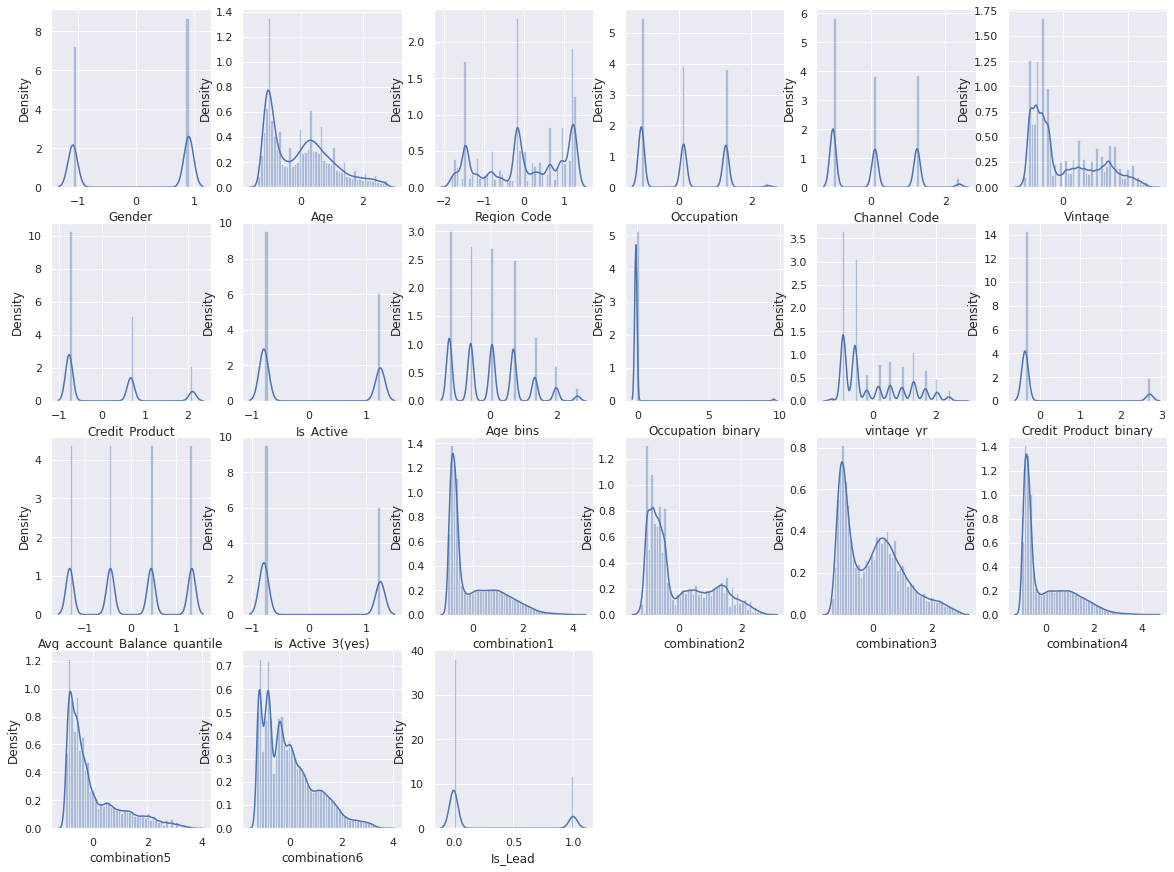

In [47]:
# plot the histogram of a variable from the dataset to see the skewness
var=train_scl.columns

plt.figure(figsize=(20,19))
i=0
for col in var:
    i+=1
    plt.subplot(5,6,i)
    sns.distplot(train_scl[col])
    
plt.show()

In [48]:
# Lets check the skewness of the features
var=train_scl.columns
skew_list=[]
for i in var:
    skew_list.append(train_scl[i].skew())
tmp=pd.concat([pd.DataFrame(var,columns=["Features"]),pd.DataFrame(skew_list,columns=["Skewness"])],axis=1) 
tmp.set_index("Features",inplace=True)

tmp.T

Features    Gender       Age  Region_Code  Occupation  Channel_Code   Vintage  \
Skewness -0.185298  0.618992     -0.26556    0.303374      0.386726  0.790189   

Features  Credit_Product  Is_Active  Age_bins  Occupation_binary  ...  \
Skewness        0.937704   0.458036  0.525495           9.441791  ...   

Features  Credit_Product_binary  Avg_account_Balance_quantile  \
Skewness               2.348393                      0.000071   

Features  is_Active_3(yes)  combination1  combination2  combination3  \
Skewness          0.458036      1.040296      0.803279      0.624767   

Features  combination4  combination5  combination6   Is_Lead  
Skewness      1.048691      1.346272      0.905815  1.235596  

[1 rows x 21 columns]

In [49]:
# Filtering the features which has skewness less than -1 and greater than +1
skewed=tmp.loc[(tmp["Skewness"]>1) | (tmp["Skewness"]<-1)].index
print(skewed)

Index(['Occupation_binary', 'Credit_Product_binary', 'combination1',
       'combination4', 'combination5', 'Is_Lead'],
      dtype='object', name='Features')


In [50]:
# preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
pt=PowerTransformer(copy=False)
# Fitting the power transformer in train data
train_scl["Occupation_binary"]=pt.fit_transform(train_scl[["Occupation_binary"]])
train_scl["Occupation_binary"]=pt.transform(train_scl[["Occupation_binary"]])

train_scl['Credit_Product_binary'] = pt.fit_transform(train_scl[['Credit_Product_binary']])
train_scl['Credit_Product_binary'] = pt.transform(train_scl[['Credit_Product_binary']])

train_scl['combination1'] = pt.fit_transform(train_scl[['combination1']])
train_scl['combination1'] = pt.transform(train_scl[['combination1']])

train_scl['combination4'] = pt.fit_transform(train_scl[['combination4']])
train_scl['combination4'] = pt.transform(train_scl[['combination4']])

train_scl['combination5'] = pt.fit_transform(train_scl[['combination5']])
train_scl['combination5'] = pt.transform(train_scl[['combination5']])

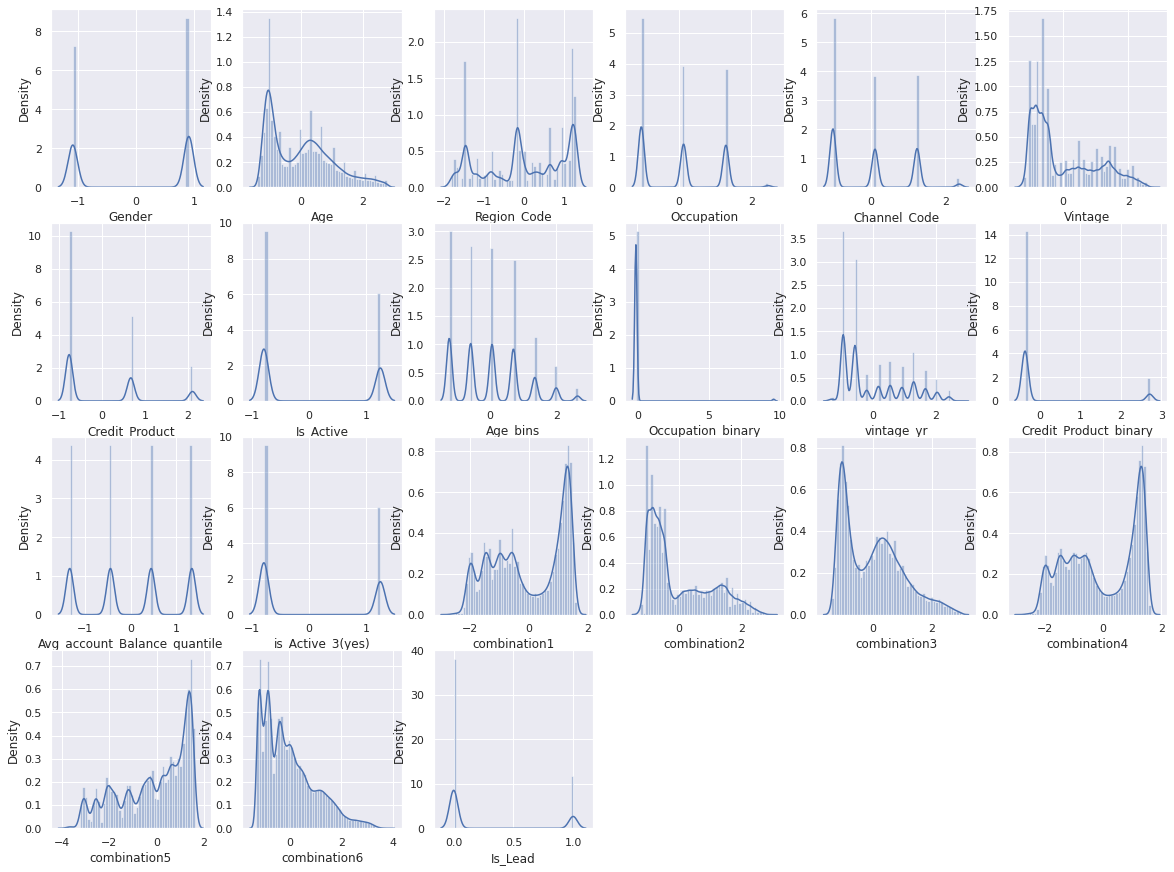

In [51]:
# plot the histogram of a variable from the dataset to see the skewness
var=train_scl.columns
plt.figure(figsize=(20,19))
i=0
for col in var:
    i+=1
    plt.subplot(5,6,i)
    sns.distplot(train_scl[col])
    
plt.show()

## Class analysis

In [52]:
classes=train_scl["Is_Lead"].value_counts()
islead_0=round(classes[0]/train_scl["Is_Lead"].count()*100,2)
islead_1=round(classes[1]/train_scl["Is_Lead"].count()*100,2)
islead_0,islead_1

(76.28, 23.72)

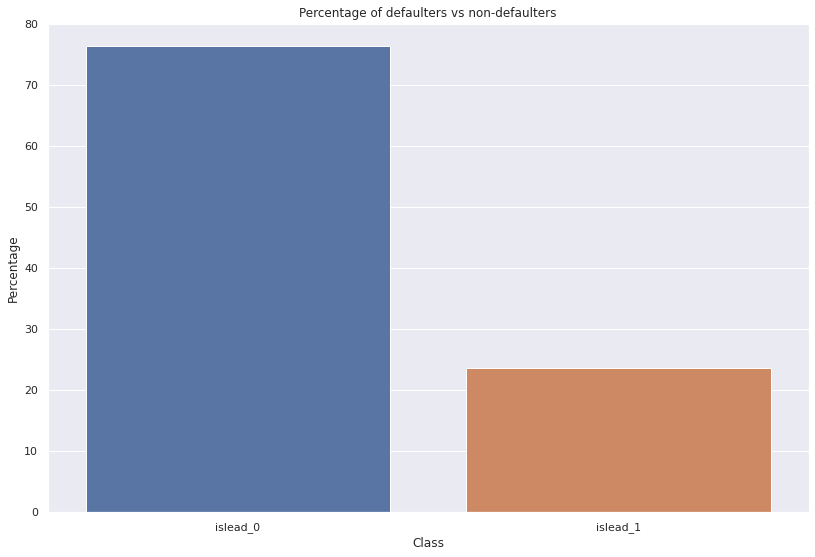

In [53]:
# Create a bar plot for the number and percentage of islead_0 vs islead_1
plt.figure(figsize=(30,9))
plt.subplot(1,2,2)
islead_percentage={"Class":["islead_0","islead_1"],"Percentage":[islead_0,islead_1]}
df_islead_percentage=pd.DataFrame(islead_percentage)
sns.barplot(x="Class",y="Percentage",data=df_islead_percentage)
plt.title('Percentage of defaulters vs non-defaulters')

plt.show()

# Test Data Processing

In [54]:
test_raw     = pd.read_csv('test_mSzZ8RL.csv')
#Data encoding
test_raw['Gender']               = test_raw['Gender'].replace({'Female':0,'Male':1})
test_raw["Occupation"]           = test_raw["Occupation"].replace({"Self_Employed":1,"Salaried":2,"Other":3,"Entrepreneur":4})
test_raw["Channel_Code"]         = test_raw["Channel_Code"].replace({'X1':'1','X2':'2','X3':'3','X4':'4'})
test_raw["Credit_Product"]       = test_raw["Credit_Product"].replace({'No':'1','Yes':'2'})
test_raw["Is_Active"]            = test_raw["Is_Active"].replace({'No':'1','Yes':'2'})
test_raw["Region_Code"]          = test_raw["Region_Code"].apply(lambda x:x[2:])


test_raw["Credit_Product"] = test_raw["Credit_Product"].fillna(3)

test_raw["Region_Code"]      = pd.to_numeric(test_raw["Region_Code"])
test_raw["Channel_Code"]     = pd.to_numeric(test_raw["Channel_Code"])
test_raw["Credit_Product"]   = pd.to_numeric(test_raw["Credit_Product"])
test_raw["Is_Active"]        = pd.to_numeric(test_raw["Is_Active"])

test_raw['Age_bins'] = np.array(np.floor(np.array(test_raw['Age']) / 10.))

occupation_binary = np.array(test_raw['Occupation'])
test_raw['Occupation_binary'] = test_raw['Occupation'].map(lambda x: 1 if x == 4 else 0)

test_raw['vintage_yr'] = np.array(np.floor(np.array(test_raw['Vintage']) / 12.))

Credit_Product_binary = np.array(test_raw['Credit_Product'])
test_raw['Credit_Product_binary'] = test_raw['Credit_Product'].map(lambda x: 1 if x == 3 else 0)

quantiles_range = [0, .25, .5, .75, 1.]
quantiles = test_raw['Avg_Account_Balance'].quantile(quantiles_range)
quantile_labels = ['25', '50', '75', '100']
test_raw['Avg_Account_Balance_quantile'] = pd.qcut(test_raw['Avg_Account_Balance'], q=quantiles_range, labels=quantile_labels)
test_raw['Avg_Account_Balance_quantile'] = pd.to_numeric(test_raw["Avg_Account_Balance_quantile"])

test_raw['Avg_Account_Balance_log'] = np.log((1 + test_raw['Avg_Account_Balance']))

test_raw['Avg_Account_Balance_monthly'] = np.array(np.floor(np.array(test_raw['Avg_Account_Balance']) / 12.))

is_Active = np.array(test_raw['Is_Active'])
test_raw['is_Active_3(yes)'] = test_raw['Is_Active'].map(lambda x: 3 if x == 2 else 0)

test_raw['combination1']   = test_raw['Age']  * test_raw['Vintage']
test_raw['combination2']   = test_raw['Vintage']  * test_raw['Region_Code'] 
test_raw['combination3']   = test_raw['Region_Code'] * test_raw['Age']
test_raw['combination4']   = test_raw['Age']  * test_raw['Vintage'] * test_raw['Region_Code']
test_raw['combination5']   = test_raw['Vintage']  * test_raw['Region_Code'] * test_raw['Avg_Account_Balance_quantile'] 
test_raw['combination6']   = test_raw['Avg_Account_Balance_quantile'] * test_raw['Age']  * test_raw['Avg_Account_Balance_log']

test_raw.drop(['ID'], axis = 1, inplace=True)
test_raw.drop(['Avg_Account_Balance'], axis = 1, inplace=True)
test_raw.drop(['Avg_Account_Balance_log'], axis=1, inplace=True)
test_raw.drop(['Avg_Account_Balance_monthly'], axis=1, inplace=True)

std_scl = preprocessing.StandardScaler() #instance of preprocessing
cols = test_raw.columns.values
test_scl = pd.DataFrame(std_scl.fit_transform(test_raw[cols]), columns = cols)

# Lets check the skewness of the features
var = test_scl.columns
skew_list = []
for i in var:
    skew_list.append(test_scl[i].skew())

tmp = pd.concat([pd.DataFrame(var, columns=["Features"]), pd.DataFrame(skew_list, columns=["Skewness"])], axis=1)
tmp.set_index("Features", inplace=True)

# Filtering the features which has skewness less than -1 and greater than +1
skewed = tmp.loc[(tmp["Skewness"] > 1) | (tmp["Skewness"] <-1 )].index
for i in skewed:
  # preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
  pt = PowerTransformer(copy=False)
  # Fitting the power transformer in train data
  test_scl[i] = pt.fit_transform(test_scl[[i]])
test_scl

Gender       Age  Region_Code  Occupation  Channel_Code   Vintage  \
0       0.908299 -0.999878    -1.451764    1.294862     -1.019283 -0.676804   
1       0.908299 -0.058563    -0.167798    1.294862      0.112272  0.066841   
2       0.908299 -0.865404     0.015626    0.121541     -1.019283 -1.017641   
3       0.908299 -0.999878     0.199050    1.294862     -1.019283 -0.428922   
4      -1.100959 -0.999878     0.015626    1.294862     -1.019283 -0.862715   
...          ...       ...          ...         ...           ...       ...   
105307  0.908299  0.546567    -0.167798    0.121541      0.112272  1.213293   
105308  0.908299  0.748278     0.657609    1.294862      0.112272  1.213293   
105309  0.908299 -0.596457    -1.451764    0.121541      2.375382 -0.986656   
105310  0.908299  0.613804    -1.451764    1.294862      1.243827  1.430189   
105311  0.908299 -1.134351    -1.268341    0.121541     -1.019283 -0.800745   

        Credit_Product  Is_Active  Age_bins  Occupation_binary  vintage_yr  \
0             0.668140  -0.806682 -1.227360          -0.101601   -0.557444   
1             2.101608  -0.806682  0.059855          -0.101601    0.188648   
2            -0.765327  -0.806682 -0.583752          -0.101601   -0.930490   
3            -0.765327  -0.806682 -1.227360          -0.101601   -0.557444   
4            -0.765327  -0.806682 -1.227360          -0.101601   -0.930490   
...                ...        ...       ...                ...         ...   
105307        0.668140   1.239646  0.703463          -0.101601    1.307787   
105308        0.668140  -0.806682  0.703463          -0.101601    1.307787   
105309       -0.765327  -0.806682 -0.583752          -0.101601   -0.930490   
105310       -0.765327   1.239646  0.703463          -0.101601    1.307787   
105311       -0.765327  -0.806682 -1.227360          -0.101601   -0.930490   

        Credit_Product_binary  Avg_Account_Balance_quantile  is_Active_3(yes)  \
0                   -0.367355                     -0.447214         -0.806682   
1                    2.722161                      0.447214         -0.806682   
2                   -0.367355                     -1.341641         -0.806682   
3                   -0.367355                     -0.447214         -0.806682   
4                   -0.367355                     -0.447214         -0.806682   
...                       ...                           ...               ...   
105307              -0.367355                      1.341641          1.239646   
105308              -0.367355                      0.447214         -0.806682   
105309              -0.367355                      1.341641         -0.806682   
105310              -0.367355                     -0.447214          1.239646   
105311              -0.367355                     -1.341641         -0.806682   

        combination1  combination2  combination3  combination4  combination5  \
0          -0.850543     -0.717857     -1.094687     -0.890025     -0.718565   
1           0.271557      0.051070     -0.081181      0.259745      0.651221   
2          -1.159932     -1.009238     -0.849964     -1.153544     -1.447281   
3          -0.622351     -0.420127     -0.967451     -0.612920     -0.355746   
4          -1.032426     -0.856178     -0.981588     -1.026919     -0.903657   
...              ...           ...           ...           ...           ...   
105307      1.171673      1.175323      0.506741      1.157965      1.570821   
105308      1.233526      1.263078      0.823370      1.255675      1.320043   
105309     -1.060398     -1.005837     -0.723215     -1.088209     -0.537080   
105310      1.278580      1.240402      0.391204      1.206018      0.868849   
105311     -1.015316     -0.828287     -1.205349     -1.041210     -1.306289   

        combination6  
0          -0.778098  
1           0.191249  
2          -1.173659  
3          -0.769198  
4          -0.785041  
...              ...  
105307      1.566507  
105308

# Model Building

In [55]:
# Creating function to display ROC-AUC score, f1 score and classification report
def display_scores(y_test,y_pred):
    '''
    Display ROC-AUC score, f1 score and classification report of a model.
    '''
    print(f"F1 Score : {round(f1_score(y_test,y_pred)*100,2)}%")
    print(f"Classification Report : \n {classification_report(y_test,y_pred)}")
    

In [56]:
# ROC Curve function

def draw_roc(actual,probs):
    fpr,tpr,thresholds=metrics.roc_curve(actual,probs,
                                        drop_intermediate=False)
    auc_score=metrics.roc_auc_score(actual,probs)
    plt.figure(figsize=(12,10))
    plt.plot(fpr,tpr,label="ROC Curve (area = %0.2f)"%auc_score)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim(0.0,1.05)
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return None

In [57]:
cols=list(train_scl.columns)
cols.remove("Is_Lead")
print(cols)

['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Is_Active', 'Age_bins', 'Occupation_binary', 'vintage_yr', 'Credit_Product_binary', 'Avg_account_Balance_quantile', 'is_Active_3(yes)', 'combination1', 'combination2', 'combination3', 'combination4', 'combination5', 'combination6']


In [58]:
X=train_scl[cols]
y=train_scl["Is_Lead"]

In [59]:
# Spltting the into 80:20 train test size
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(196580, 20)
(49145, 20)
(196580,)
(49145,)


## XGboost

In [60]:
# specify model
params = {'learning_rate': 0.003,
          'max_depth': 100, 
          'n_estimators':200,
          'subsample':0.3,
          'eval_metric' : 'auc',
         'objective':'binary:logistic'}
xgb_model = XGBClassifier(params = params)
# fit the model
xgb_model.fit(X_train, y_train)

[17:45:41] WARNING: ../src/learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:45:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              params={'eval_metric': 'auc', 'learning_rate': 0.003,
                      'max_depth': 100, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.3},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [61]:
xgb_model.score(X_train,y_train)

0.8690914640349985

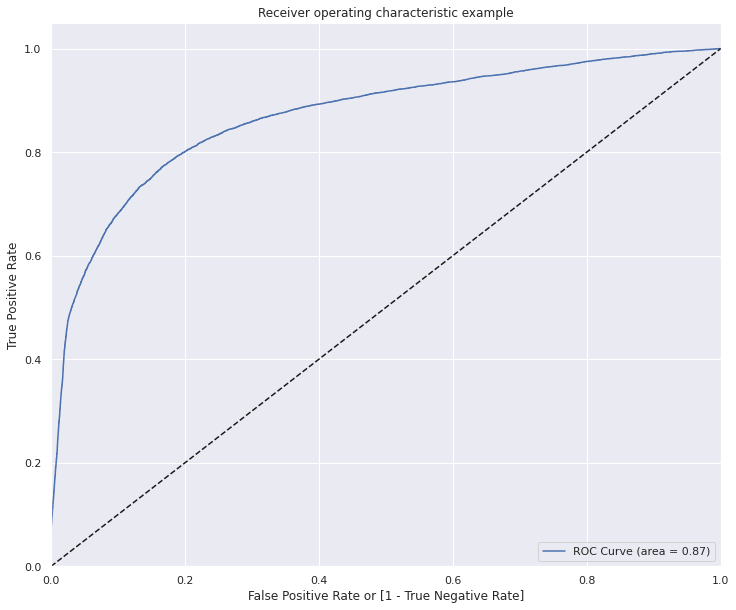

In [62]:
# Predicted probability
y_pred=xgb_model.predict_proba(X_val)[:,1]

# Plot the ROC curve
draw_roc(y_val,y_pred)

In [63]:
xgb_test_preds=xgb_model.predict(test_scl)
sample_data["Is_Lead"]=pd.Series(xgb_test_preds)
sample_data.to_csv("xgb_result.csv",index=False)
sample_data

ID  Is_Lead
0       VBENBARO        0
1       CCMEWNKY        1
2       VK3KGA9M        0
3       TT8RPZVC        0
4       SHQZEYTZ        0
...          ...      ...
105307  DBENJOYI        1
105308  CWQ72DWS        1
105309  HDESC8GU        0
105310  2PW4SFCA        0
105311  F2NOYPPZ        0

[105312 rows x 2 columns]

# Other models

## CatBoost

In [64]:
from catboost import CatBoostClassifier,Pool,cv
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### LGM classifier

In [65]:
lgm = LGBMClassifier(n_estimators=5000,
                   random_state=1994,
                   learning_rate=0.01,
                   colsample_bytree=0.5,
                   reg_alpha=4,
                   min_split_gain=0.2,
                   min_child_samples=2,
                   bagging_fraction=0.9,
                   max_depth=100)

lgm.fit(X_train,y_train, eval_set=[(X_val, y_val)], eval_metric='AUC', early_stopping_rounds=200, verbose=200)
p = lgm.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val, p))

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.869402	valid_0's binary_logloss: 0.363391
[400]	valid_0's auc: 0.871679	valid_0's binary_logloss: 0.348329
[600]	valid_0's auc: 0.872135	valid_0's binary_logloss: 0.346234
[800]	valid_0's auc: 0.872168	valid_0's binary_logloss: 0.345843
[1000]	valid_0's auc: 0.872149	valid_0's binary_logloss: 0.345756
Early stopping, best iteration is:
[825]	valid_0's auc: 0.87218	valid_0's binary_logloss: 0.345814
0.8721804124538598


In [66]:
lgm_test_preds = lgm.predict(test_scl)
sample_data['Is_Lead'] = pd.Series(lgm_test_preds)
sample_data.to_csv('lgm_result.csv', index=False)

### Catboost

In [67]:
cb = CatBoostClassifier(n_estimators=3000, 
                        random_state=1994,
                        eval_metric='AUC',
                        learning_rate=0.01,
                        random_strength=200,
                        bagging_temperature=0.6,
                        l2_leaf_reg=4,
                        one_hot_max_size=10)

cb.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], early_stopping_rounds=100, verbose=200)
p = cb.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val,p))

0:	test: 0.7838189	test1: 0.7819621	best: 0.7819621 (0)	total: 195ms	remaining: 9m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8558852867
bestIteration = 4

Shrink model to first 5 iterations.
0.8558852867001399


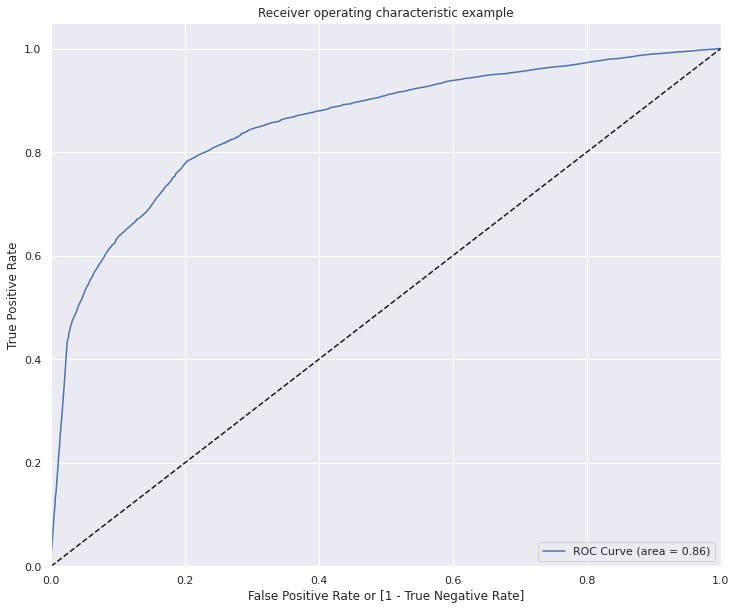

In [68]:
# Plot the ROC curve
draw_roc(y_val, p)

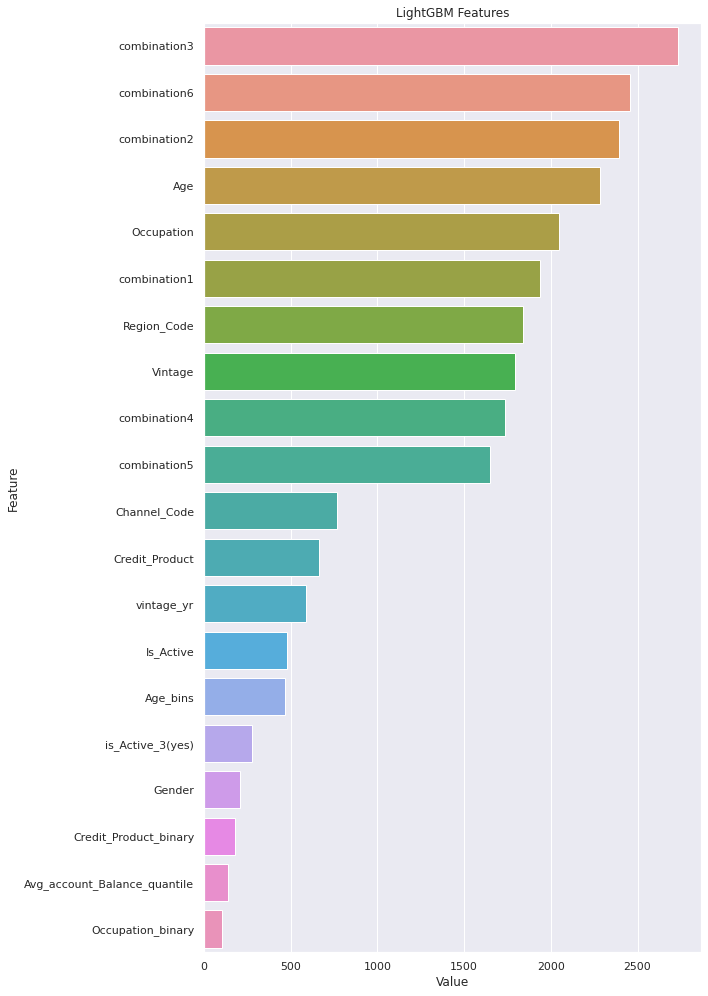

In [69]:
feature_imp=pd.DataFrame(sorted(zip(lgm.feature_importances_,X.columns),reverse=True)[:200],
                               columns=["Value","Feature"])
plt.figure(figsize=(10,14))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

# Dealing with imbalance Data

## Random Oversampling

In [71]:
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [72]:
from collections import Counter
# Befor sampling class distribution
print("Before Sampling Class Distribution : -",Counter(y_train))
# new class distribution 
print("New Class Distribution :-",Counter(y_over))

Before Sampling Class Distribution : - Counter({0: 149917, 1: 46663})
New Class Distribution :- Counter({0: 149917, 1: 149917})


### Decision Tree

In [74]:
param_grid={
    "max_depth":range(5,15,5),
    "min_samples_leaf":range(50,150,50),
    "min_samples_split":range(50,150,50)
}
# Instantiate the grid search model
dtree=DecisionTreeClassifier()
grid_search=GridSearchCV(estimator=dtree,
                        param_grid=param_grid,
                        scoring="roc_auc",
                        cv=3,
                        n_jobs=-1,
                        verbose=1)

# Fit the grid search to the data
grid_search.fit(X_over,y_over)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [75]:
# Printing the optimal roc score and hyperparameters
print("Best roc auc score : ",grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc auc swcore :  0.8766108076051823
DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)


In [76]:
# Model with optimal hyperparameters
dt_over_model=DecisionTreeClassifier(criterion="gini",
                                    random_state=100,
                                    max_depth=10,
                                    min_samples_leaf=50,
                                    min_samples_split=50)
dt_over_model.fit(X_over,y_over)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

In [77]:
# Predictions on the val set
y_val_pred=dt_over_model.predict(X_val)
display_scores(y_val,y_val_pred)

F1 Score : 66.4%
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.83      0.87     37520
           1       0.59      0.76      0.66     11625

    accuracy                           0.82     49145
   macro avg       0.75      0.80      0.77     49145
weighted avg       0.84      0.82      0.82     49145



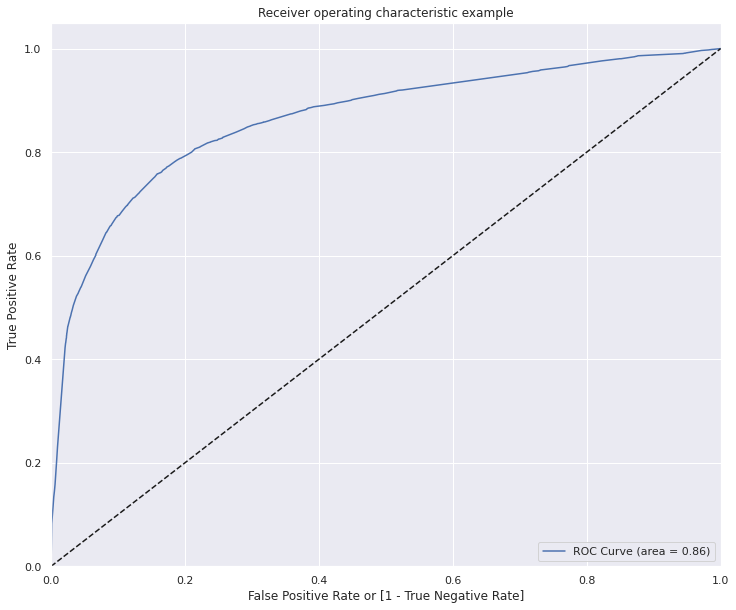

In [78]:
# Predicted probability
y_val_pred_proba = dt_over_model.predict_proba(X_val)[:,1]
# Plot the ROC curve
draw_roc(y_val, y_val_pred_proba)